# Gradient descent algorithm for Scenario 2


In this part, we implement an gradient descent algorithm to optimization the objective loss function in Scenario 2:


$$\min F := \min \frac{1}{2(n-i)} \sum_{i=1000}^n (fbpredic(i) + a*tby(i) +b*ffr(i) + c*fta(i) - asp(i))^2$$

Gradient descent: 

$$ \beta_k = \beta_{k-1} + \delta* \nabla F, $$
where $\delta$ control how far does each iteration go.


### Detailed plan

First, split the data as train and test with 80% and 20% respectively. For the training part, we need prophet() predicted price, there are a couple of issues. One is prophet() can not predict too far in the future. The other is we can not call prophet() too many times, this takes a lot of time. So we will use a sliding window strategy:

1, Split the train data as train_1 and train_2, where train_1 is used as a sliding window to fit prophet(), and give predictions in train_2. Train_2 is used train the model we proposed above.

2, After we got full size (size of train_2) predictions from prophet(), then we use gradient descent to fit the above model, extracting the coefficients of features to make predicution in the testing data.

In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from numpy import meshgrid

## For plotting
import matplotlib.pyplot as plt
from matplotlib import style
import datetime as dt
import seaborn as sns
sns.set_style("whitegrid")

In [53]:
path = '/Users/yuqingdai/Documents/GitHub/Stock-Erdos/Data/dff1.csv'


In [54]:
df= pd.read_csv(path)
df = df.rename(columns = {"Date":"ds","Close":"y"}) 
# df = df[['ds', 'y', 'tby', 'ffr', 'fta', 'eps', 'div', 'une', 'wti', 'ppi',
       'rfs', 'fbsp', 'diff']]
df.columns
# len(df)

Index(['ds', 'y', 'tby', 'ffr', 'fta', 'eps', 'div', 'une', 'wti', 'ppi',
       'rfs', 'fbsp', 'diff'],
      dtype='object')

In [38]:
cutoff = len(df) - 252
df_train = df[:cutoff].copy()
df_test = df[cutoff:].copy()

In [39]:
cutoff

2300

In [40]:
df.columns

Index(['ds', 'y', 'fbsp', 'diff', 'tby', 'ffr', 'fta', 'eps', 'div', 'per',
       'une', 'rus', 'wti', 'ppi', 'rfs', 'vix'],
      dtype='object')

In [44]:
possible_features = ['tby', 'ffr', 'fta', 'eps', 'div', 'per',
       'une', 'rus', 'wti', 'ppi', 'rfs', 'vix']

In [45]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(fit_intercept=False, normalize=True, copy_X = True)
reg.fit(df_train[possible_features], df_train['diff'])



LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)

In [46]:
coef = []
for i in range(len(possible_features)):
    coef.append(np.round(reg.coef_[i],5))

print(coef)

[-100.62561, -109.40681, -0.00012, -7.62296, -503.12708, -4.51267, 72.64922, 0.65432, 2.3687, -2.48918, 0.00454, -10.15371]


In [47]:
pp_test = df_test.fbsp.copy() # predicted price on testing data 
pp_train = df_train.fbsp.copy() # predicted price on training data

In [48]:
df_test1 = df_test[possible_features].copy()
df_train1 = df_train[possible_features].copy()

In [49]:
for i in range(len(possible_features)):
    pp_test += coef[i] * df_test1[df_test1.columns[i]].ravel()
    pp_train += coef[i] * df_train1[df_train1.columns[i]].ravel()

In [50]:
from sklearn.metrics import mean_squared_error as MSE
# MSE for test data
# Actual close price: df_test[:test_time].y 
# Predicted price by prophet: pred_test
# Predicted price by tuning 
mse1 = MSE(df_test.y, df_test.fbsp) #
mse2 = MSE(df_test.y, pp_test)
print(mse1,mse2)

15046.462930803766 15411.239134274298


In [51]:
# MSE for train data
mse3 = MSE(df_train.y, df_train.fbsp)
mse4 = MSE(df_train.y, pp_train)
print(mse3,mse4)

17643.826224878187 4235.06678063686


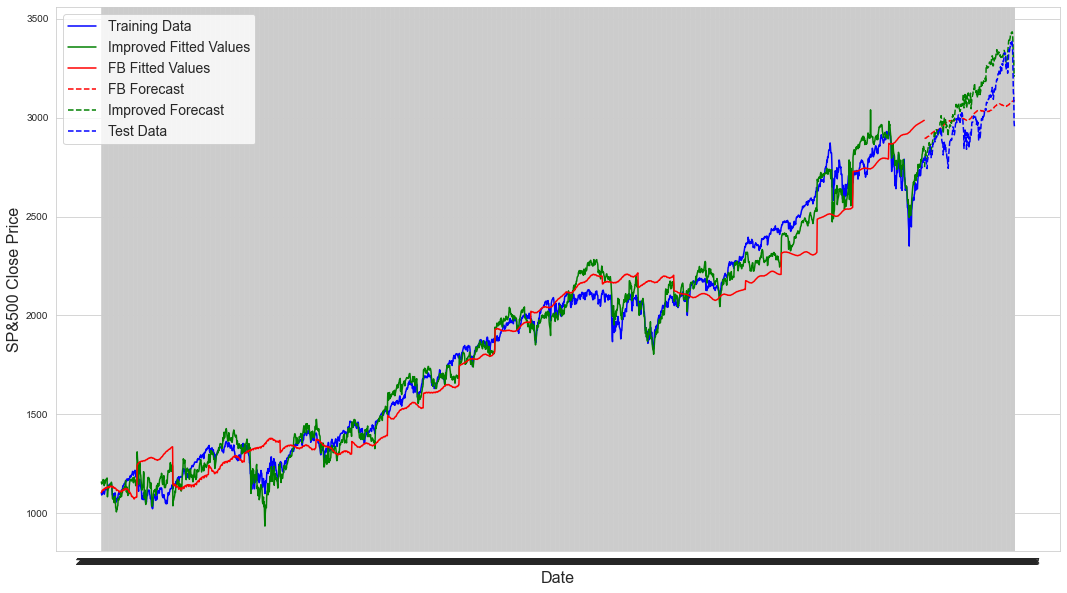

In [52]:

plt.figure(figsize=(18,10))

# plot the training data
plt.plot(df_train.ds,df_train.y,'b',
            label = "Training Data")

plt.plot(df_train.ds, pp_train,'g-',
            label = "Improved Fitted Values")

# plot the fit
plt.plot(df_train.ds, df_train.fbsp,'r-',
            label = "FB Fitted Values")

# # plot the forecast
plt.plot(df_test.ds, df_test.fbsp,'r--',
            label = "FB Forecast")
plt.plot(df_test.ds, pp_test,'g--',
            label = "Improved Forecast")
plt.plot(df_test.ds,df_test.y,'b--',
            label = "Test Data")

plt.legend(fontsize=14)

plt.xlabel("Date", fontsize=16)
plt.ylabel("SP&500 Close Price", fontsize=16)

plt.show()